In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from pathlib import Path
from itertools import product

import numpy as np
import polars as pl
import pandas as pd
from tueplots import bundles
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so

from monithor.benchmark.analysis import (
    benchmark_stats,
    DISTANCE_KEY,
    roc_curve,
    roc_metrics,
)
from monithor.benchmark import get_benchmark

# Paths to data and paper
GENERATED_DIR = Path("generated/")
PAPER_DIR = Path("paper/")

(PAPER_DIR / "figures").mkdir(exist_ok=True, parents=True)
(PAPER_DIR / "tables").mkdir(exist_ok=True, parents=True)

# Info about benchmarks
EQUIVALENT_TASKS = {
    # Model stealing in ModelReuse is a label extraction method but with a
    # different arch.
    "steal": "label_extraction",
    # Knowledge distillation in ModelReuse is a probit extraction method, but
    # with the same arch
    "distill": "probit_extraction",
    # Group fineprune from SACBench with the rest of the pruning techniques
    "fineprune": "prune",
}
BENCH_SHORT_NAMES = {
    "ModelReuse": "ModelReuse",
    "SACBenchmark": "SACBench",
}
BENCH_NAME = pl.concat_str("benchmark", "dataset", separator="\n").alias("bench_name")

# Display names of baselines and distances
BASELINES = (
    (
        (pl.col("split") == "test")
        & (pl.col("sampler") == "Random")
        & (pl.col("representation") == "Logits")
        & (pl.col("distance") == "cosine")
    )
    | (
        (pl.col("split") == "test")
        & (pl.col("sampler") == "Random")
        & (pl.col("representation") == "Labels")
        & (pl.col("distance") == "hamming")
    )
    | (
        (pl.col("split") == "test")
        & (pl.col("sampler") == "Negative")
        & (pl.col("representation") == "Labels")
        & (pl.col("distance") == "hamming")
    )
    | (
        (pl.col("split") == "test")
        & (pl.col("sampler") == "Negative")
        & (pl.col("representation") == "Logits")
        & (pl.col("distance") == "cosine")
    )
)
DISTANCE_NAME = pl.concat_str(
    pl.col("split"),
    pl.col("sampler"),
    pl.col("representation"),
    pl.col("distance"),
    separator="+",
).alias("distance_name")
LOGITS = ~pl.col("representation").str.contains_any(["Hard", "Label"]).alias("logits")

DISTANCE_NAMES = pl.DataFrame(
    iter(
        {
            "test+Negative+Labels+hamming": "AKH baseline (ours)",
            "test+Random+Labels+hamming": "Random Sampling",
            "train+Boundary+Labels+hamming": "IPGuard",
            "train+Adversarial+DDV+cosine": "ModelDiff",
            "train+NegativeAugment+SAC+l2": "SAC",
            "train+RandomSubsample100+ZLIME+l2": "ZestOfLime",
        }.items()
    ),
    schema=["distance_name", "display_name"],
)
DISTANCE_ORDER = DISTANCE_NAMES["display_name"].to_list()

TASK_ORDER = [
    "same",
    "prune",
    "quantize",
    "finetune",
    "transfer",
    "label_extraction",
    "adv_label_extraction",
    "probit_extraction",
]

# Plotting
plt.rcParams.update(**bundles.aaai2024())
HEIGHT, WIDTH = bundles.aaai2024()["figure.figsize"]

pl.Config.restore_defaults()
pl.Config.set_tbl_cols(20)
pl.Config.set_tbl_rows(15)
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

# Generation of the seeds used in the experiments

In the experiments, we set the initial randomness of `numpy` and `torch` with a seed. The seeds used 
in the paper were generated as follows.

In [4]:
ENTROPY = 123456789
SEEDS = np.random.SeedSequence(ENTROPY).generate_state(5)
SEEDS

array([1315320158, 1391606125,  150704254, 2614738243, 1968368282],
      dtype=uint32)

# Breakdown by benchmark

In [5]:
stats_list = []
roc_stats_list = []
perfs_list = []

for seed, benchmark in product(SEEDS, BENCH_SHORT_NAMES.keys()):
    # Get the distance measurement results
    bench = get_benchmark(benchmark, Path("data/"), Path("models/"), "cpu")
    print(seed, benchmark)
    results = bench.from_records(GENERATED_DIR / str(seed) / benchmark)

    # Get the ROC curves for all the datasets and fingerprints
    bench_perfs = roc_curve(
        results,
        key=DISTANCE_KEY,
        score=1 - pl.col("value"),
        true_value=pl.col("variation_name") != "unrelated",
    ).with_columns(
        benchmark=pl.lit(benchmark).replace(BENCH_SHORT_NAMES),
        seed=pl.lit(seed).cast(pl.Int64),
    )
    perfs_list.append(bench_perfs)

    # Get the AUC and FPR@5% for all the datasets and fingerprints
    roc_stats = (
        roc_metrics(
            results,
            key=DISTANCE_KEY + ["source_model"],
            score=1 - pl.col("value"),
            true_value=pl.col("variation_name") != "unrelated",
        )
        .group_by(DISTANCE_KEY)
        .mean()
        .with_columns(
            benchmark=pl.lit(benchmark).replace(BENCH_SHORT_NAMES),
            seed=pl.lit(seed).cast(pl.Int64),
        )
    )
    roc_stats_list.append(roc_stats)

    # Get the models accuracy and oracle distances between the model pairs
    accuracy = pl.read_csv(
        GENERATED_DIR / "bench_eval" / benchmark / "*" / "accuracy.csv"
    )
    oracle_distance = pl.read_parquet(
        GENERATED_DIR / "bench_eval" / benchmark / "*" / "*-oracle_distance.pq"
    )
    bench_stats, _, _ = benchmark_stats(
        results,
        accuracy,
        oracle_distance,
        split="test",
    )

    bench_stats = bench_stats.with_columns(
        pl.col("task").replace(EQUIVALENT_TASKS),
        benchmark=pl.lit(benchmark).replace(BENCH_SHORT_NAMES),
        seed=pl.lit(seed).cast(pl.Int64),
    )
    stats_list.append(bench_stats)

bench_stats: pl.DataFrame = pl.concat(stats_list)
bench_stats = (
    bench_stats.with_columns(BENCH_NAME).group_by(
        "benchmark",
        "dataset",
        "split",
        "bench_name",
        "task",
        "source_model",
        "target_model",
        "variation_name",
    )
    # Average over the seeds
    .agg(
        pl.col(
            "hamming",
            "conditioned_hamming",
            "corrected_hamming",
            "source_accuracy",
            "target_accuracy",
            "diff_but_accurate",
            "accuracy_diff",
            "l2",
        ).mean()
    )
)
melted_bench_stats = bench_stats.melt(
    id_vars=[
        # "seed",  # Values are the same for all the seeds so no need to group by seed
        "benchmark",
        "dataset",
        "split",
        "task",
        "source_model",
        "target_model",
        "variation_name",
    ],
    value_vars=[
        "hamming",
        "accuracy_diff",
        "l2",
        "corrected_hamming",
    ],
    value_name="metric",
    variable_name="metric_name",
).sort("metric_name")
roc_stats: pl.DataFrame = pl.concat(roc_stats_list)
perfs: pl.DataFrame = pl.concat(perfs_list)

1315320158 ModelReuse
1315320158 SACBenchmark
1391606125 ModelReuse
1391606125 SACBenchmark
150704254 ModelReuse
150704254 SACBenchmark
2614738243 ModelReuse
2614738243 SACBenchmark
1968368282 ModelReuse
1968368282 SACBenchmark


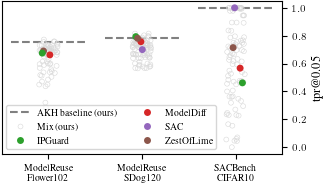

In [10]:
metric = "tpr@0.05"
budget = 200
baseline = "test+Negative+Labels+hamming"
perfs_flattenend = (
    roc_stats.filter(pl.col("budget") == budget, DISTANCE_NAME != baseline)
    .group_by(
        "benchmark",
        "dataset",
        "split",
        "sampler",
        "representation",
        "distance",
        "budget",
    )
    .agg(
        pl.col("auc", "tpr@0.05").mean(),
        pl.col("auc", "tpr@0.05").std().name.suffix("_std"),
    )
    .with_columns(DISTANCE_NAME)
    .join(DISTANCE_NAMES, on="distance_name", how="left")
    # .with_columns(display_name=pl.col("display_name")),
    .with_columns(
        BENCH_NAME, display_name=pl.col("display_name").fill_null("Mix (ours)")
    )
    .sort("bench_name")
)
distance_order = DISTANCE_ORDER.copy()
distance_order.remove("Random Sampling")
colors = {
    distance: color for distance, color in zip(DISTANCE_ORDER, sns.color_palette())
}
colors["Mix (ours)"] = (0.85, 0.85, 0.85)

baseline_perfs = {
    record["bench_name"]: record[metric]
    for record in roc_stats.filter(
        # pl.col("split") == split,
        pl.col("budget") == budget,
        DISTANCE_NAME == baseline,
    )
    .with_columns(BENCH_NAME)
    .sort("bench_name")
    .to_dicts()
}

plt.rcParams.update(**bundles.aaai2024(ncols=1, rel_width=1.1))
fig, ax = plt.subplots()
ax: plt.Axes
for i, (name, value) in enumerate(baseline_perfs.items()):
    ax.hlines(
        value,
        i - 0.4,
        i + 0.4,
        label="AKH baseline (ours)" if i == 0 else None,
        ls="--",
        color="gray",
    )


sns.stripplot(
    perfs_flattenend.filter(pl.col("display_name") == "Mix (ours)"),
    ax=ax,
    x="bench_name",
    y=metric,
    hue="display_name",
    palette=colors,
    size=4,
    marker="$\\circ$",
)
sns.stripplot(
    perfs_flattenend.filter(
        pl.col("display_name") != "Mix (ours)",
        pl.col("display_name") != "Random Sampling",
    ),
    ax=ax,
    x="bench_name",
    y=metric,
    hue="display_name",
    hue_order=distance_order[1:],
    palette=colors,
    size=5,
    # marker="X",
)
ax.legend(title=None)
ax.set_xlabel("")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
sns.move_legend(ax, "lower left", ncols=2)
fig.set_size_inches(3.3, 1.9)

fig.savefig(PAPER_DIR / "figures" / f"best_{metric}_{budget}_baseline-{baseline}.pdf")
fig.savefig(PAPER_DIR / "figures" / f"best_{metric}_{budget}_baseline-{baseline}.svg")

/home/agodinot/micromamba/envs/monithor/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


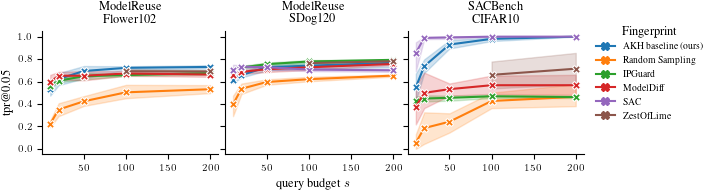

In [11]:
metric = "tpr@0.05"

fig = sns.relplot(
    roc_stats.filter(pl.col("budget") <= 200)
    .with_columns(DISTANCE_NAME, BENCH_NAME)
    .join(DISTANCE_NAMES, on="distance_name", how="inner")
    .with_columns(is_baseline=pl.col("display_name").str.contains("baseline"))
    .sort("display_name", "bench_name"),
    x="budget",
    y=metric,
    hue="display_name",
    hue_order=DISTANCE_ORDER,
    kind="line",
    col="bench_name",
    col_wrap=4,
    dashes=False,
    markers=True,
    marker="X",
)
sns.move_legend(
    fig, "upper left", bbox_to_anchor=(0.71, 1), ncol=1, title="Fingerprint"
)

fig.set_axis_labels(x_var="")
fig.facet_axis(0, 1).set_xlabel("query budget $s$")

fig.facet_axis(0, 0).set_title("ModelReuse\nFlower102")
fig.facet_axis(0, 1).set_title("ModelReuse\nSDog120")
fig.facet_axis(0, 2).set_title("SACBench\nCIFAR10")
fig.figure.set_size_inches(7.975, 1.510787071530517)
fig.savefig(PAPER_DIR / "figures" / f"{metric}_vs_budget.svg")
fig.savefig(PAPER_DIR / "figures" / f"{metric}_vs_budget.pdf")

# How to explain the difference between the benchmarks ?

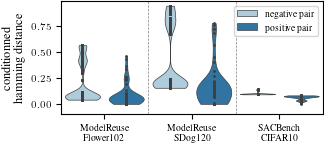

In [12]:
fig, ax = plt.subplots()
ax: plt.Axes

sns.violinplot(
    bench_stats.with_columns(
        positive=pl.when(pl.col("variation_name") != "unrelated")
        .then(pl.lit("positive pair"))
        .otherwise(pl.lit("negative pair")),
    ).sort("bench_name", "positive"),
    ax=ax,
    x="bench_name",
    y="conditioned_hamming",
    hue="positive",
    gap=0.2,
    inner="point",
    density_norm="width",
    width=1,
    linewidth=0.5,
    cut=0,
    palette="Paired",
)

n_benchs = bench_stats["bench_name"].n_unique()
n_tasks = bench_stats["task"].n_unique()

ylims = ax.get_ylim()
xlims = ax.get_xlim()
indicator_h = 0.05 * (ylims[1] - ylims[0])

for i in range(n_benchs):
    ax.axvline(0.5 + i, ls="--", linewidth=0.5, color="grey")

ax.set_xlim(xlims)
ax.set_ylim(ylims[0] - indicator_h, ylims[1])

sns.move_legend(ax, "upper right", title=None)
ax.set_ylabel("conditionned\nhamming distance")
ax.set_xlabel(None)

filename = PAPER_DIR / "figures" / "conditioned_hamming.svg"
filename.parent.mkdir(parents=True, exist_ok=True)
fig.set_size_inches(3.3, 1.5)
fig.savefig(PAPER_DIR / "figures" / "conditioned_hamming.pdf")
fig.savefig(PAPER_DIR / "figures" / "conditioned_hamming.svg")

# Potential improvements using QRD

/tmp/ipykernel_19587/4232386299.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


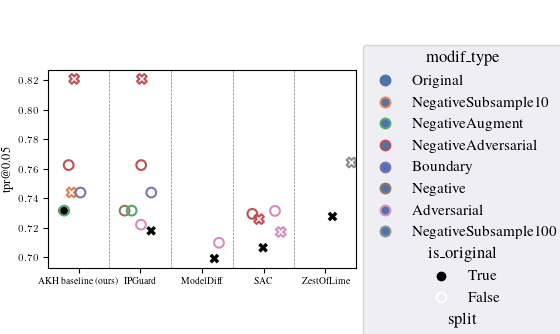

In [30]:
pl.Config.set_tbl_rows(50)
pl.Config.set_tbl_cols(50)
dataset = "Flower102"


original_perfs = (
    roc_stats.filter(pl.col("budget") == 100)
    .with_columns(DISTANCE_NAME)
    .join(DISTANCE_NAMES, on="distance_name", how="inner")
    .filter(
        ~pl.col("display_name").is_in(
            ["NegativeLabels\n(baseline, ours)", "Random Sampling"]
        )
    )
)

improvements = (
    roc_stats.join(
        original_perfs,
        on=["dataset", "benchmark", "budget", "seed", "representation"],
        suffix="_original",
    )
    .with_columns(
        is_original=(pl.col("split") == pl.col("split_original"))
        & (pl.col("sampler") == pl.col("sampler_original"))
        & (pl.col("distance") == pl.col("distance_original")),
        delta_tpr=pl.col("tpr@0.05") - pl.col("tpr@0.05_original"),
    )
    .group_by(
        "benchmark",
        # "dataset",
        "display_name",
        "split",
        "sampler",
        "representation",
        "distance",
        "is_original",
    )
    .agg(pl.col("delta_tpr").mean(), pl.col("tpr@0.05").mean())
    .filter(
        pl.col("delta_tpr") >= 0, pl.col("benchmark") == "ModelReuse"
    )  # , pl.col("dataset") == dataset)
    .with_columns(
        # BENCH_NAME,
        DISTANCE_NAME,
        modif_type=pl.when(pl.col("is_original") == True)
        .then(pl.lit("Original"))
        .otherwise("sampler"),
    )
    .sort("benchmark", "display_name", "modif_type", descending=[False, False, True])
)

fig, ax = plt.subplots()
plotter = (
    so.Plot(
        improvements,
        x="display_name",
        y="tpr@0.05",
        edgecolor="modif_type",
        color="is_original",
        alpha="is_original",
        edgealpha="is_original",
        marker="split",
        text="distance_name",
        group="sampler",
    )
    # .facet("bench_name")
    .add(
        so.Dot(pointsize=7, edgewidth=1.5),
        so.Dodge(by=["group"]),
        so.Jitter(x=0.3, seed=12345666),
    )
    .scale(
        color={True: "black", False: "white"},
        alpha={True: 1, False: 0},
        edgealpha={True: 0, False: 1},
    )
    .label(x="")
    .share(x=False, y=False)
    # .layout(size=(1.2, 2.8))
    # .show()
    .on(ax)
    .plot()
)

n_fingerprints = improvements["display_name"].n_unique()
for i in range(n_fingerprints):
    ax.axvline(0.5 + i, ls="--", linewidth=0.5, color="grey")

fig.show()

# List of tasks per benchmark

In [27]:
new_index = [
    ("model leak", "same"),
    ("model leak", "quantize"),
    ("model leak", "finetune"),
    ("model leak", "transfer"),
    ("model leak", "prune"),
    ("Label extraction", "label_extraction"),
    ("Label extraction", "adv_label_extraction"),
    ("Probit extraction", "probit_extraction"),
]
rename = {
    "label_extraction": "vanilla",
    "probit_extraction": "vanilla",
    "adv_label_extraction": "adversarial",
    "display_name": "Fingerprint",
}

bench_tasks_table = (
    bench_stats.group_by("bench_name")
    .agg(pl.col("task").unique().sort())
    .explode("task")
    .with_columns(dummy=pl.lit("\\checkmark"))
    .pivot(
        index="task",
        columns="bench_name",
        values="dummy",
        sort_columns=True,
    )
    .fill_null("$\\times$")
    .sort("task")
    .to_pandas()
    .set_index("task")
)

bench_tasks_table = bench_tasks_table.loc[[idx[1] for idx in new_index], :]
bench_tasks_table.index = pd.MultiIndex.from_tuples(new_index)
bench_tasks_table = bench_tasks_table.rename(index=rename)

with open(PAPER_DIR / "tables" / f"bench_tasks_list.tex", "w") as file:
    table = (
        bench_tasks_table.style
        # .hide(axis="index")
        .to_latex(
            clines="skip-last;data",
            convert_css=True,
            position_float="centering",
            # multicol_align="c",
            column_format="@{}p{1cm} p{1cm} p{1.4cm} p{1.4cm} p{1.4cm}@{}",
            hrules=True,
            caption="Stealing and obfuscation methods implemented by different benchmarks.",
            label="tab:bench_tasks",
            position="t",
            # environment="table*",
        )
    )

    # Add command to setup font size
    second_line_idx = table.find("\n", 1) + 1
    table = table[:second_line_idx] + "\\small\n" + table[second_line_idx:]
    file.write(table)

bench_tasks_table

ModelReuse\nFlower102 ModelReuse\nSDog120  \
model leak        same                   \checkmark          \checkmark   
                  quantize               \checkmark          \checkmark   
                  finetune                 $\times$            $\times$   
                  transfer                 $\times$            $\times$   
                  prune                  \checkmark          \checkmark   
Label extraction  vanilla                \checkmark          \checkmark   
                  adversarial              $\times$            $\times$   
Probit extraction vanilla                \checkmark          \checkmark   

                              SACBench\nCIFAR10  
model leak        same               \checkmark  
                  quantize             $\times$  
                  finetune           \checkmark  
                  transfer           \checkmark  
                  prune              \checkmark  
Label extraction  vanilla            \checkmark  
                  adversarial        \checkmark  
Probit extraction vanilla            \checkmark

# Breakdown by task

In [28]:
task_stats_list = []
task_roc_stats_list = []

for seed, benchmark in product(SEEDS, BENCH_SHORT_NAMES):
    # Get the distance measurement results
    bench = get_benchmark(benchmark, "data/", "models/", "cpu")
    results = bench.from_records(GENERATED_DIR / str(seed) / benchmark)

    # Get the AUC and FPR@5% for all the benchmarks and datasets
    bench_perfs = roc_curve(
        results,
        key=DISTANCE_KEY + ["task"],
        score=pl.col("value"),
        true_value=pl.col("variation_name") != "unrelated",
    )
    task_roc_stats = (
        roc_metrics(
            results,
            key=DISTANCE_KEY + ["task", "source_model"],
            score=1 - pl.col("value"),
            true_value=pl.col("variation_name") != "unrelated",
        )
        .group_by(DISTANCE_KEY + ["task"])
        .mean()
        .with_columns(
            LOGITS,
            DISTANCE_NAME,
            benchmark=pl.lit(benchmark).replace(BENCH_SHORT_NAMES),
            seed=pl.lit(seed).cast(pl.Int64),
        )
    )
    task_roc_stats_list.append(task_roc_stats)

    # Get the models accuracy and oracle distances between the model pairs
    accuracy = pl.read_csv(
        GENERATED_DIR / "bench_eval" / benchmark / "*" / "accuracy.csv"
    )
    oracle_distance = pl.read_parquet(
        GENERATED_DIR / "bench_eval" / benchmark / "*" / "*-oracle_distance.pq"
    )
    task_bench_stats, _, _ = benchmark_stats(
        results,
        accuracy,
        oracle_distance,
        split="test",
    )

    task_bench_stats = task_bench_stats.with_columns(
        pl.col("task").replace(EQUIVALENT_TASKS),
        benchmark=pl.lit(benchmark).replace(BENCH_SHORT_NAMES),
        seed=pl.lit(seed).cast(pl.Int64),
    )
    task_stats_list.append(task_bench_stats)


task_bench_stats: pl.DataFrame = pl.concat(task_stats_list)
task_bench_stats = (
    task_bench_stats.with_columns(BENCH_NAME)
    .sort("bench_name")
    .melt(
        id_vars=[
            "benchmark",
            "dataset",
            "split",
            "bench_name",
            "task",
            "source_model",
            "target_model",
            "variation_name",
        ],
        value_vars=[
            "hamming",
            "accuracy_diff",
            "l2",
            "target_accuracy",
            "corrected_hamming",
        ],
        value_name="metric",
        variable_name="metric_name",
    )
    .sort("metric_name")
)
task_roc_stats: pl.DataFrame = pl.concat(task_roc_stats_list).with_columns(BENCH_NAME)

In [29]:
metric = "tpr@0.05"
budget = 100

tasks_perfs = (
    task_roc_stats.filter(pl.col("budget") == budget)
    .join(DISTANCE_NAMES, on="distance_name", how="inner")
    .with_columns(pl.col("task").replace(EQUIVALENT_TASKS))
    # First, need to average for each task (per seed) because some tasks contain
    # perfs from different benchmarks
    .group_by("display_name", "task", "seed")
    .agg(pl.col(metric).mean())
    # Then, computes average and convidence intervals over the seeds
    .group_by("display_name", "task")
    .agg(
        display_metric=pl.concat_str(
            pl.col(metric).mean().round(2),
            (0.95 * pl.col(metric).std() / pl.col(metric).len().sqrt())
            .round(2)
            .cast(pl.String)
            .str.replace("0.", ".")
            .str.replace("^.0$", "0"),
            separator=" ± \\scriptsize",
        )
    )
    # Finally, pivot the table to have a column per task and a line per
    # fingerprint
    .pivot(values="display_metric", index="display_name", columns="task")
    .sort("display_name")
)

new_index = [
    ("", "display_name"),
    ("model leak", "same"),
    ("model leak", "quantize"),
    ("model leak", "finetune"),
    ("model leak", "transfer"),
    ("model leak", "prune"),
    ("Probit extraction", "probit_extraction"),
    ("Label extraction", "label_extraction"),
    ("Label extraction", "adv_label_extraction"),
]
rename = {
    "label_extraction": "vanilla",
    "probit_extraction": "vanilla",
    "adv_label_extraction": "adversarial",
    "display_name": "Fingerprint",
}

# Make sure the cols are in the right order
pandas_tasks_perfs = tasks_perfs.to_pandas()[[col[1] for col in new_index]]
# Replace the index
pandas_tasks_perfs.columns = pd.MultiIndex.from_tuples(new_index)
# Rename the ugly task names
pandas_tasks_perfs = pandas_tasks_perfs.rename(columns=rename)

with open(PAPER_DIR / "tables" / f"{metric}-{budget}-tasks_perfs.tex", "w") as file:
    table = (
        pandas_tasks_perfs.style.hide(axis="index")
        .highlight_max(
            axis="index",
            subset=pandas_tasks_perfs.columns[1:],
            props="font-weight:bold;",
        )
        .to_latex(
            clines="skip-last;data",
            convert_css=True,
            position_float="centering",
            multicol_align="c",
            column_format="l|lllll|ll|l",
            hrules=True,
            caption="$\\text{TPR}@0.05$ of the existing fingerprints with a budget of 100 queries. For each task, the best performance are highlighted.",
            label="tab:task_perf",
            position="t",
            environment="table*",
        )
    )

    # Add command to setup font size
    second_line_idx = table.find("\n", 1) + 1
    table = table[:second_line_idx] + "\\small\n" + table[second_line_idx:]
    file.write(table)

pandas_tasks_perfs

model leak                         \
           Fingerprint                same               quantize   
0  AKH baseline (ours)  1.0 ± \scriptsize0     1.0 ± \scriptsize0   
1              IPGuard  1.0 ± \scriptsize0     1.0 ± \scriptsize0   
2            ModelDiff  1.0 ± \scriptsize0     1.0 ± \scriptsize0   
3      Random Sampling  1.0 ± \scriptsize0  0.93 ± \scriptsize.03   
4                  SAC  1.0 ± \scriptsize0     1.0 ± \scriptsize0   
5           ZestOfLime  1.0 ± \scriptsize0     1.0 ± \scriptsize0   

                                                                     \
             finetune               transfer                  prune   
0  1.0 ± \scriptsize0     1.0 ± \scriptsize0  0.91 ± \scriptsize.01   
1  1.0 ± \scriptsize0     1.0 ± \scriptsize0  0.94 ± \scriptsize.01   
2  1.0 ± \scriptsize0     1.0 ± \scriptsize0  0.94 ± \scriptsize.01   
3  1.0 ± \scriptsize0   0.48 ± \scriptsize.2  0.71 ± \scriptsize.02   
4  1.0 ± \scriptsize0     1.0 ± \scriptsize0    0.92 ± \scriptsize0   
5  1.0 ± \scriptsize0  0.78 ± \scriptsize.17    0.86 ± \scriptsize0   

       Probit extraction       Label extraction                         
                 vanilla                vanilla            adversarial  
0  0.78 ± \scriptsize.01  0.46 ± \scriptsize.01  0.92 ± \scriptsize.03  
1  0.64 ± \scriptsize.02    0.12 ± \scriptsize0  0.02 ± \scriptsize.01  
2  0.59 ± \scriptsize.05  0.15 ± \scriptsize.02  0.16 ± \scriptsize.07  
3  0.46 ± \scriptsize.01  0.07 ± \scriptsize.02  0.06 ± \scriptsize.05  
4    0.81 ± \scriptsize0  0.59 ± \scriptsize.02     1.0 ± \scriptsize0  
5  0.74 ± \scriptsize.02  0.38 ± \scriptsize.05  0.29 ± \scriptsize.11